21/21 [==============================] - 1s 2ms/step

Fold 1:
Train RMSE: 4.33096
Validation RMSE: 4.64008
Train MAE: 3.20785
Validation MAE: 3.45891
Train R2: 0.99529
Validation R2: 0.99437

Computation calculations for Fold 1:
Execution Time: 13.68 seconds
CPU Usage: 12.6%
Memory Used: 17741.20 MB
21/21 [==============================] - 1s 2ms/step

Fold 2:
Train RMSE: 4.29052
Validation RMSE: 3.77430
Train MAE: 3.09068
Validation MAE: 2.69041
Train R2: 0.99544
Validation R2: 0.99586

Computation calculations for Fold 2:
Execution Time: 14.42 seconds
CPU Usage: 26.0%
Memory Used: 17804.89 MB
21/21 [==============================] - 1s 2ms/step

Fold 3:
Train RMSE: 4.93540
Validation RMSE: 3.70551
Train MAE: 3.31240
Validation MAE: 2.83529
Train R2: 0.99416
Validation R2: 0.99544

Computation calculations for Fold 3:
Execution Time: 14.67 seconds
CPU Usage: 27.1%
Memory Used: 17830.11 MB
21/21 [==============================] - 1s 2ms/step

Fold 4:
Train RMSE: 4.95063
Validation RMSE

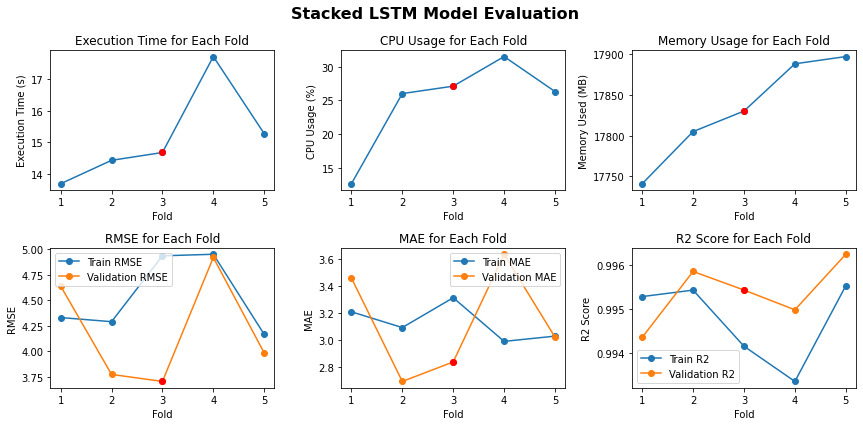

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import psutil
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations',
                'Definitive/Provisional']

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Smooth the target variable using a 13-month moving average
window = 13
smoothed_target = np.convolve(target.squeeze(), np.ones(window)/window, mode='valid')
smoothed_target = smoothed_target.reshape(-1, 1)

# Normalize the target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(smoothed_target)

# Define number of folds
num_folds = 5

# Compute fold size
fold_size = len(target_scaled) // num_folds

# Initialize lists to store evaluation metrics and computation calculations for each fold
eval_metrics = []
execution_times = []
cpu_usages = []
memory_usages = []

# Initialize variables for best fold and metric
best_fold = 0
best_metric = float('inf')

# Perform k-fold cross-validation
for fold in range(1, num_folds + 1):
    # Define the training and validation data for the current fold
    start_index = (fold - 1) * fold_size
    end_index = fold * fold_size
    val_data = target_scaled[start_index:end_index]
    train_data = np.concatenate((target_scaled[:start_index], target_scaled[end_index:]))

    def train_evaluate_model(train_data, val_data):
        X_train, y_train = train_data[:-1], train_data[1:]
        X_val, y_val = val_data[:-1], val_data[1:]

        # Define and train the Stacked LSTM model
        model = Sequential()
        model.add(LSTM(64, return_sequences=True, input_shape=(1, 1)))
        model.add(LSTM(64))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')
        model.fit(X_train, y_train, epochs=50, verbose=0)

        # Make predictions
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)

        # Invert the scaling
        train_predictions = scaler.inverse_transform(train_predictions)
        y_train = scaler.inverse_transform(y_train)
        val_predictions = scaler.inverse_transform(val_predictions)
        y_val = scaler.inverse_transform(y_val)

        # Calculate evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
        val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
        train_mae = mean_absolute_error(y_train, train_predictions)
        val_mae = mean_absolute_error(y_val, val_predictions)
        train_r2 = r2_score(y_train, train_predictions)
        val_r2 = r2_score(y_val, val_predictions)

        # Print evaluation metrics for the current fold
        print(f"\nFold {fold}:")
        print(f"Train RMSE: {train_rmse:.5f}")
        print(f"Validation RMSE: {val_rmse:.5f}")
        print(f"Train MAE: {train_mae:.5f}")
        print(f"Validation MAE: {val_mae:.5f}")
        print(f"Train R2: {train_r2:.5f}")
        print(f"Validation R2: {val_r2:.5f}")

        # Store evaluation metrics for the current fold
        eval_metrics.append((train_rmse, val_rmse, train_mae, val_mae, train_r2, val_r2))

        return train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions

    # Train and evaluate the Stacked LSTM model
    start_time = time.time()
    train_rmse, val_rmse, y_train, train_predictions, y_val, val_predictions = train_evaluate_model(train_data, val_data)
    computation_time = time.time() - start_time

    # Measure CPU usage during model training
    cpu_usage = psutil.cpu_percent()

    # Record computation calculations
    execution_times.append(computation_time)
    cpu_usages.append(cpu_usage)
    memory_usages.append(psutil.virtual_memory().used / 1024 / 1024)  # Memory usage in MB

    # Check if current fold has the best metric
    if val_rmse < best_metric:
        best_metric = val_rmse
        best_fold = fold

    # Print computation calculations for the current fold
    print(f"\nComputation calculations for Fold {fold}:")
    print(f"Execution Time: {computation_time:.2f} seconds")
    print(f"CPU Usage: {cpu_usage}%")
    print(f"Memory Used: {psutil.virtual_memory().used / 1024 / 1024:.2f} MB")

# Print the evaluation metrics for the best fold
best_train_rmse, best_val_rmse, best_train_mae, best_val_mae, best_train_r2, best_val_r2 = eval_metrics[best_fold - 1]
print(f"\nBest Fold: {best_fold}")
print(f"Best Train RMSE: {best_train_rmse:.5f}")
print(f"Best Validation RMSE: {best_val_rmse:.5f}")
print(f"Best Train MAE: {best_train_mae:.5f}")
print(f"Best Validation MAE: {best_val_mae:.5f}")
print(f"Best Train R2: {best_train_r2:.5f}")
print(f"Best Validation R2: {best_val_r2:.5f}")

# Plot computation calculations for each fold
plt.figure(figsize=(12, 6))
plt.suptitle('Stacked LSTM Model Evaluation', fontsize=16, fontweight='bold')


plt.subplot(231)
plt.plot(range(1, num_folds + 1), execution_times, 'o-')
plt.plot(best_fold, execution_times[best_fold - 1], 'ro')
plt.title('Execution Time for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Execution Time (s)')

plt.subplot(232)
plt.plot(range(1, num_folds + 1), cpu_usages, 'o-')
plt.plot(best_fold, cpu_usages[best_fold - 1], 'ro')
plt.title('CPU Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('CPU Usage (%)')

plt.subplot(233)
plt.plot(range(1, num_folds + 1), memory_usages, 'o-')
plt.plot(best_fold, memory_usages[best_fold - 1], 'ro')
plt.title('Memory Usage for Each Fold')
plt.xlabel('Fold')
plt.ylabel('Memory Used (MB)')

# Plot evaluation metrics for each fold
plt.subplot(234)
train_rmses = [metrics[0] for metrics in eval_metrics]
val_rmses = [metrics[1] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_rmses, 'o-', label='Train RMSE')
plt.plot(range(1, num_folds + 1), val_rmses, 'o-', label='Validation RMSE')
plt.plot(best_fold, best_val_rmse, 'ro')
plt.title('RMSE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(235)
train_maes = [metrics[2] for metrics in eval_metrics]
val_maes = [metrics[3] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_maes, 'o-', label='Train MAE')
plt.plot(range(1, num_folds + 1), val_maes, 'o-', label='Validation MAE')
plt.plot(best_fold, best_val_mae, 'ro')
plt.title('MAE for Each Fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.legend()

plt.subplot(236)
train_r2_scores = [metrics[4] for metrics in eval_metrics]
val_r2_scores = [metrics[5] for metrics in eval_metrics]
plt.plot(range(1, num_folds + 1), train_r2_scores, 'o-', label='Train R2')
plt.plot(range(1, num_folds + 1), val_r2_scores, 'o-', label='Validation R2')
plt.plot(best_fold, best_val_r2, 'ro')
plt.title('R2 Score for Each Fold')
plt.xlabel('Fold')
plt.ylabel('R2 Score')
plt.legend()

plt.tight_layout()
plt.show()


3/3 [==============================] - 0s 3ms/step
Train RMSE: 23.196714129029164
Test RMSE: 39.58183630683986
Train MAE: 16.809094761106124
Test MAE: 30.77403917984225
Train R2: 0.7734132913885543
Test R2: 0.38172380237700976


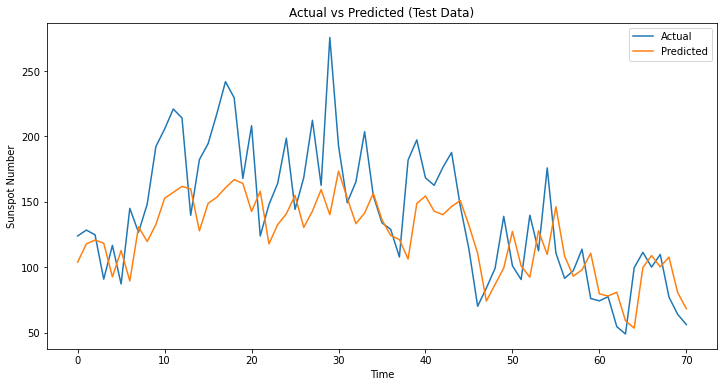

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import psutil
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations',
                'Definitive/Provisional']

# Filter the data for the desired interval
start_year = 1875
end_year = 1941
filtered_data = data[(data['Year'] >= start_year) & (data['Year'] <= end_year)]

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = filtered_data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing datasets
train_data = target_scaled[:-72]  # 720 months for training
test_data = target_scaled[-72:]  # 72 months for testing

def train_evaluate_model(train_data, test_data):
    X_train, y_train = train_data[:-1], train_data[1:]
    X_test, y_test = test_data[:-1], test_data[1:]

    # Define and train the Stacked LSTM model
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(1, 1)))
    model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=50, verbose=0)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Invert the scaling
    train_predictions = scaler.inverse_transform(train_predictions)
    y_train = scaler.inverse_transform(y_train)
    test_predictions = scaler.inverse_transform(test_predictions)
    y_test = scaler.inverse_transform(y_test)

    # Calculate evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Print evaluation metrics
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train R2:", train_r2)
    print("Test R2:", test_r2)

    # Plot actual vs predicted values for the test data
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(test_predictions, label='Predicted')
    plt.title('Actual vs Predicted (Test Data)')
    plt.xlabel('Time')
    plt.ylabel('Sunspot Number')
    plt.legend()
    plt.show()

# Train and evaluate the Stacked LSTM model
train_evaluate_model(train_data, test_data)


3/3 [==============================] - 0s 2ms/step

Evaluation metrics for Hidden Units = 15:
Train RMSE: 23.168376954875686
Test RMSE: 39.9851005915768
Train MAE: 16.756536768888484
Test MAE: 30.921507424368
Train R2: 0.7739665512284188
Test R2: 0.369061489219481


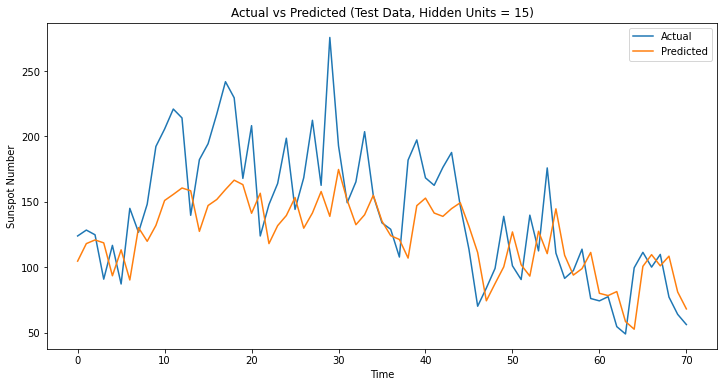

3/3 [==============================] - 0s 2ms/step

Evaluation metrics for Hidden Units = 19:
Train RMSE: 23.175928831898993
Test RMSE: 40.301143166305835
Train MAE: 16.79136348077276
Test MAE: 31.158719892904806
Train R2: 0.7738191731870936
Test R2: 0.3590481856794655


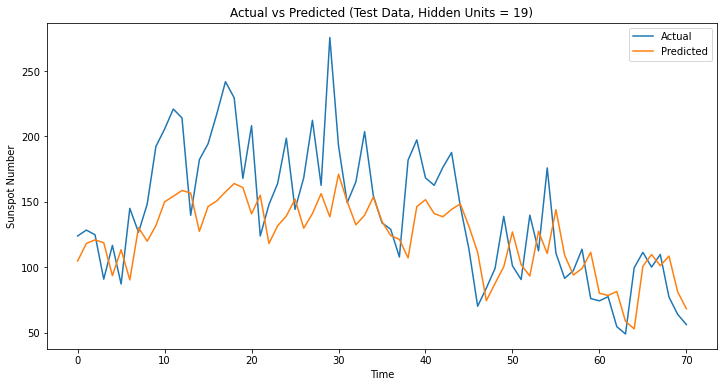

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import psutil
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations',
                'Definitive/Provisional']

# Filter the data for the desired interval
start_year = 1875
end_year = 1941
filtered_data = data[(data['Year'] >= start_year) & (data['Year'] <= end_year)]

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = filtered_data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing datasets
train_data = target_scaled[:-72]  # 720 months for training
test_data = target_scaled[-72:]  # 72 months for testing

def train_evaluate_model(train_data, test_data, hidden_units):
    X_train, y_train = train_data[:-1], train_data[1:]
    X_test, y_test = test_data[:-1], test_data[1:]

    # Define and train the Stacked LSTM model
    model = Sequential()
    model.add(LSTM(hidden_units, return_sequences=True, input_shape=(1, 1)))
    model.add(LSTM(hidden_units))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=50, verbose=0)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Invert the scaling
    train_predictions = scaler.inverse_transform(train_predictions)
    y_train = scaler.inverse_transform(y_train)
    test_predictions = scaler.inverse_transform(test_predictions)
    y_test = scaler.inverse_transform(y_test)

    # Calculate evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Print evaluation metrics
    print(f"\nEvaluation metrics for Hidden Units = {hidden_units}:")
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train R2:", train_r2)
    print("Test R2:", test_r2)

    # Plot actual vs predicted values for the test data
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(test_predictions, label='Predicted')
    plt.title(f"Actual vs Predicted (Test Data, Hidden Units = {hidden_units})")
    plt.xlabel("Time")
    plt.ylabel("Sunspot Number")
    plt.legend()
    plt.show()

# Train and evaluate the Stacked LSTM model for hidden units = 15
train_evaluate_model(train_data, test_data, hidden_units=15)

# Train and evaluate the Stacked LSTM model for hidden units = 19
train_evaluate_model(train_data, test_data, hidden_units=19)


3/3 [==============================] - 0s 2ms/step

Evaluation metrics for Hidden Units = 15:
Train RMSE: 23.192762518588058
Test RMSE: 40.48333690629146
Train MAE: 16.770767505452667
Test MAE: 31.335248125103174
Train R2: 0.7734904838851657
Test R2: 0.35323984561064437


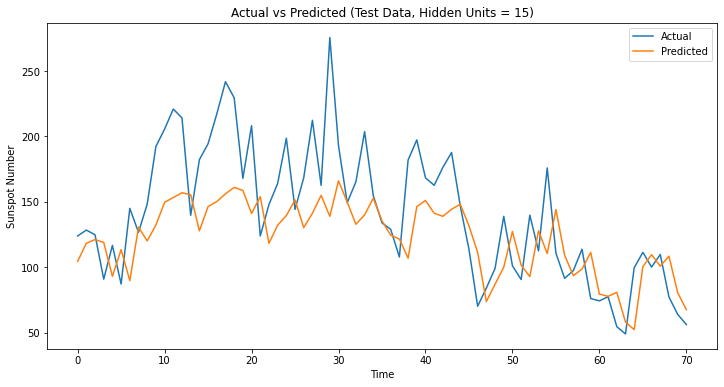

3/3 [==============================] - 0s 1ms/step

Evaluation metrics for Hidden Units = 19:
Train RMSE: 23.19509011534664
Test RMSE: 40.08531858854773
Train MAE: 16.789104961924938
Test MAE: 31.0978714419083
Train R2: 0.7734450171779732
Test R2: 0.36589477792517155


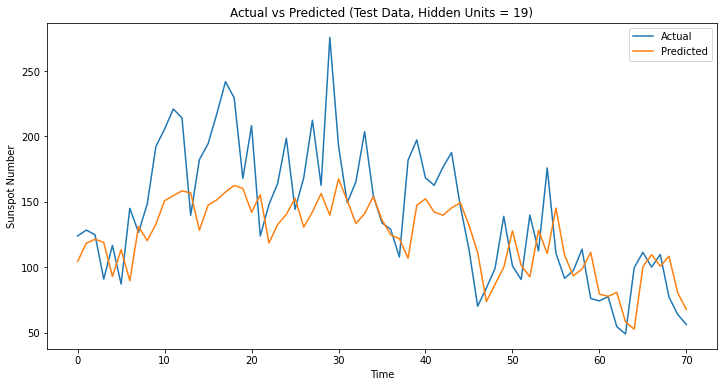

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import psutil
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations',
                'Definitive/Provisional']

# Filter the data for the desired interval
start_year = 1875
end_year = 1941
filtered_data = data[(data['Year'] >= start_year) & (data['Year'] <= end_year)]

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = filtered_data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing datasets
train_data = target_scaled[:-72]  # 720 months for training
test_data = target_scaled[-72:]  # 72 months for testing

def train_evaluate_model(train_data, test_data, hidden_units):
    X_train, y_train = train_data[:-1], train_data[1:]
    X_test, y_test = test_data[:-1], test_data[1:]

    # Define and train the LSTM model
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=50, verbose=0)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Invert the scaling
    train_predictions = scaler.inverse_transform(train_predictions)
    y_train = scaler.inverse_transform(y_train)
    test_predictions = scaler.inverse_transform(test_predictions)
    y_test = scaler.inverse_transform(y_test)

    # Calculate evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Print evaluation metrics
    print(f"\nEvaluation metrics for Hidden Units = {hidden_units}:")
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train R2:", train_r2)
    print("Test R2:", test_r2)

    # Plot actual vs predicted values for the test data
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(test_predictions, label='Predicted')
    plt.title(f"Actual vs Predicted (Test Data, Hidden Units = {hidden_units})")
    plt.xlabel("Time")
    plt.ylabel("Sunspot Number")
    plt.legend()
    plt.show()

# Train and evaluate the LSTM model for hidden units = 15
train_evaluate_model(train_data, test_data, hidden_units=15)

# Train and evaluate the LSTM model for hidden units = 19
train_evaluate_model(train_data, test_data, hidden_units=19)


C:\Users\Storm\AppData\Local\Temp/ipykernel_34556/4036172176.py:37: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)



Evaluation metrics for Random Forest:
Train RMSE: 12.360646104817281
Test RMSE: 44.04978124290876
Train MAE: 9.050760282262198
Test MAE: 34.105616364855806
Train R2: 0.9356625512993715
Test R2: 0.2342655917994837


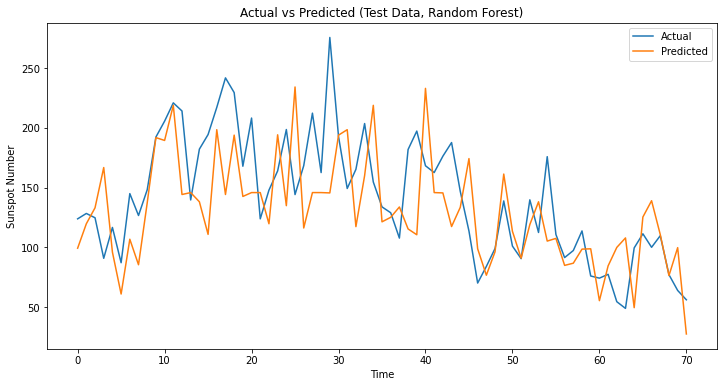

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations',
                'Definitive/Provisional']

# Filter the data for the desired interval
start_year = 1875
end_year = 1941
filtered_data = data[(data['Year'] >= start_year) & (data['Year'] <= end_year)]

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = filtered_data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Normalize the target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing datasets
train_data = target_scaled[:-72]  # 720 months for training
test_data = target_scaled[-72:]  # 72 months for testing

def train_evaluate_model(train_data, test_data):
    X_train, y_train = train_data[:-1], train_data[1:]
    X_test, y_test = test_data[:-1], test_data[1:]

    # Define and train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Invert the scaling
    train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Print evaluation metrics
    print("\nEvaluation metrics for Random Forest:")
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train R2:", train_r2)
    print("Test R2:", test_r2)

    # Plot actual vs predicted values for the test data
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(test_predictions, label='Predicted')
    plt.title("Actual vs Predicted (Test Data, Random Forest)")
    plt.xlabel("Time")
    plt.ylabel("Sunspot Number")
    plt.legend()
    plt.show()

# Train and evaluate the Random Forest model
train_evaluate_model(train_data, test_data)



Evaluation metrics for n_estimators = 15:
Train RMSE: 1.663692027153746
Test RMSE: 9.248298636624178
Train MAE: 1.1791322550631718
Test MAE: 6.917248858340421
Train R2: 0.998547883740305
Test R2: 0.9392619249108284


C:\Users\Storm\AppData\Local\Temp/ipykernel_34556/844560877.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


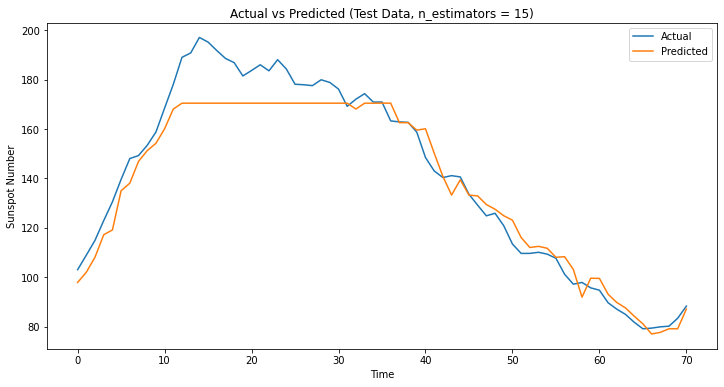


Evaluation metrics for n_estimators = 19:
Train RMSE: 1.660139848682284
Test RMSE: 9.281658732270467
Train MAE: 1.177973749916294
Test MAE: 6.955689235194441
Train R2: 0.9985540779990678
Test R2: 0.9388229506651452


C:\Users\Storm\AppData\Local\Temp/ipykernel_34556/844560877.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


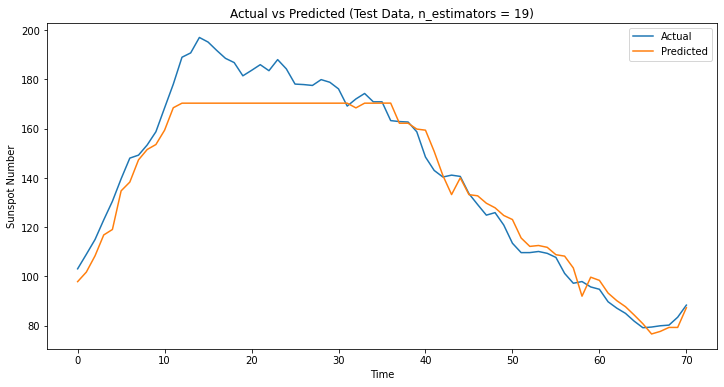

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations',
                'Definitive/Provisional']

# Filter the data for the desired interval
start_year = 1875
end_year = 1941
filtered_data = data[(data['Year'] >= start_year) & (data['Year'] <= end_year)]

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = filtered_data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Smooth the target variable using a 13-month moving average
smoothed_target = pd.Series(target.squeeze()).rolling(window=13, min_periods=1, center=True).mean().values.reshape(-1, 1)

# Normalize the smoothed target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(smoothed_target)

# Split the data into training and testing datasets
train_data = target_scaled[:-72]  # 720 months for training
test_data = target_scaled[-72:]  # 72 months for testing

def train_evaluate_model(train_data, test_data, n_estimators):
    X_train, y_train = train_data[:-1], train_data[1:]
    X_test, y_test = test_data[:-1], test_data[1:]

    # Define and train the Random Forest model
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Invert the scaling
    train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
    y_train = scaler.inverse_transform(y_train)
    test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test)

    # Calculate evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Print evaluation metrics
    print(f"\nEvaluation metrics for n_estimators = {n_estimators}:")
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train R2:", train_r2)
    print("Test R2:", test_r2)

    # Plot actual vs predicted values for the test data
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(test_predictions, label='Predicted')
    plt.title(f"Actual vs Predicted (Test Data, n_estimators = {n_estimators})")
    plt.xlabel("Time")
    plt.ylabel("Sunspot Number")
    plt.legend()
    plt.show()

# Train and evaluate the Random Forest model for n_estimators = 15
train_evaluate_model(train_data, test_data, n_estimators=15)

# Train and evaluate the Random Forest model for n_estimators = 19
train_evaluate_model(train_data, test_data, n_estimators=19)


3/3 [==============================] - 0s 2ms/step

Evaluation metrics for Hidden Units = 15:
Train RMSE: 4.253865453556709
Test RMSE: 15.847083516462797
Train MAE: 3.170588512077481
Test MAE: 12.141766744608887
Train R2: 0.9905065729742983
Test R2: 0.8216652294231147


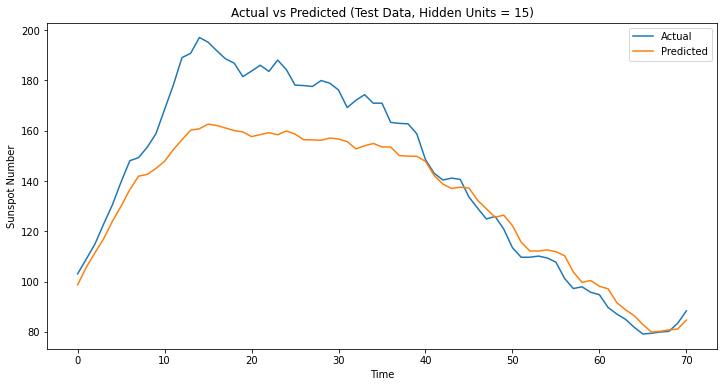

3/3 [==============================] - 0s 2ms/step

Evaluation metrics for Hidden Units = 19:
Train RMSE: 3.6363361044012703
Test RMSE: 10.677266214001646
Train MAE: 2.741730972987748
Test MAE: 8.417537953595284
Train R2: 0.9930628105716627
Test R2: 0.91904242776699


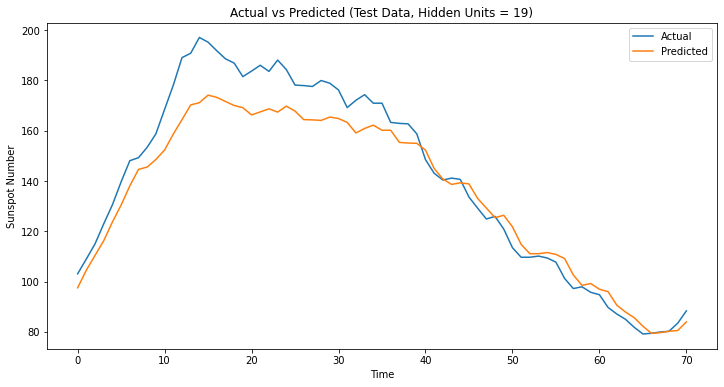

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations',
                'Definitive/Provisional']

# Filter the data for the desired interval
start_year = 1875
end_year = 1941
filtered_data = data[(data['Year'] >= start_year) & (data['Year'] <= end_year)]

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = filtered_data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Smooth the target variable using a 13-month moving average
smoothed_target = pd.Series(target.squeeze()).rolling(window=13, min_periods=1, center=True).mean().values.reshape(-1, 1)

# Normalize the smoothed target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(smoothed_target)

# Split the data into training and testing datasets
train_data = target_scaled[:-72]  # 720 months for training
test_data = target_scaled[-72:]  # 72 months for testing

def train_evaluate_model(train_data, test_data, hidden_units):
    X_train, y_train = train_data[:-1], train_data[1:]
    X_test, y_test = test_data[:-1], test_data[1:]

    # Define and train the LSTM model
    model = Sequential()
    model.add(LSTM(hidden_units, return_sequences=False, input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=50, verbose=0)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Invert the scaling
    train_predictions = scaler.inverse_transform(train_predictions)
    y_train = scaler.inverse_transform(y_train)
    test_predictions = scaler.inverse_transform(test_predictions)
    y_test = scaler.inverse_transform(y_test)

    # Calculate evaluation metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Print evaluation metrics
    print(f"\nEvaluation metrics for Hidden Units = {hidden_units}:")
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    print("Train MAE:", train_mae)
    print("Test MAE:", test_mae)
    print("Train R2:", train_r2)
    print("Test R2:", test_r2)

    # Plot actual vs predicted values for the test data
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(test_predictions, label='Predicted')
    plt.title(f"Actual vs Predicted (Test Data, Hidden Units = {hidden_units})")
    plt.xlabel("Time")
    plt.ylabel("Sunspot Number")
    plt.legend()
    plt.show()

# Train and evaluate the LSTM model for hidden units = 15
train_evaluate_model(train_data, test_data, hidden_units=15)

# Train and evaluate the LSTM model for hidden units = 19
train_evaluate_model(train_data, test_data, hidden_units=19)


C:\Users\Storm\AppData\Local\Temp/ipykernel_34556/1195160404.py:46: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best Hyperparameters:
hidden_units: 25
epochs: 150
batch_size: 128

Evaluation metrics for the best model:
Train RMSE: 3.9117104297787724
Test RMSE: 13.211187493424196
Train MAE: 2.930290304543472
Test MAE: 10.222000885188923
Train R2: 0.991972341047197
Test R2: 0.8760572733198178


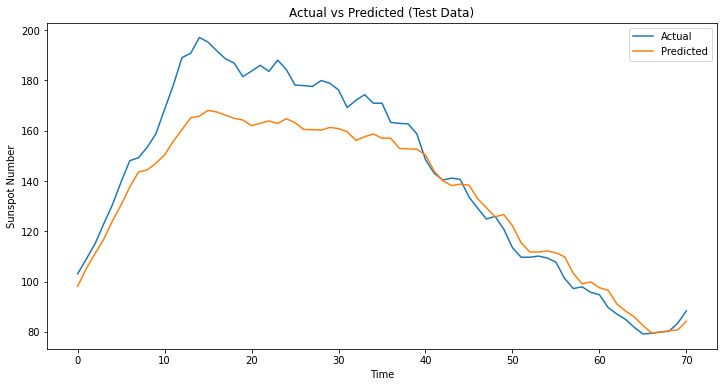

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(42)

# Load the data
data = pd.read_csv('C:/Users/Storm/Downloads/SN_m_tot_V2.0.csv', delimiter=';', header=None)
data.columns = ['Year', 'Month', 'Date', 'Monthly Mean Total Sunspot Number', 'Uncertainty', 'Observations',
                'Definitive/Provisional']

# Filter the data for the desired interval
start_year = 1875
end_year = 1941
filtered_data = data[(data['Year'] >= start_year) & (data['Year'] <= end_year)]

# Select the 'Monthly Mean Total Sunspot Number' column as the target variable
target = filtered_data['Monthly Mean Total Sunspot Number'].values.reshape(-1, 1)

# Smooth the target variable using a 13-month moving average
smoothed_target = pd.Series(target.squeeze()).rolling(window=13, min_periods=1, center=True).mean().values.reshape(-1, 1)

# Normalize the smoothed target variable
scaler = StandardScaler()
target_scaled = scaler.fit_transform(smoothed_target)

# Split the data into training and testing datasets
train_data = target_scaled[:-72]  # 720 months for training
test_data = target_scaled[-72:]  # 72 months for testing

# Define the LSTM model
def create_model(hidden_units):
    model = Sequential()
    model.add(LSTM(hidden_units, return_sequences=False, input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

# Create KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameter search space
param_grid = {
    'hidden_units': [10, 15, 20, 25],
    'batch_size': [32, 64, 128],
    'epochs': [50, 100, 150]
}

# Perform random search
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=3, scoring='neg_mean_squared_error')
random_search.fit(train_data[:-1], train_data[1:])

# Get the best model and its hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Make predictions with the best model
train_predictions = best_model.predict(train_data[:-1])
test_predictions = best_model.predict(test_data[:-1])

# Invert the scaling
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(train_data[1:])
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(test_data[1:])

# Calculate evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Print evaluation metrics
print("\nEvaluation metrics for the best model:")
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
print("Train R2:", train_r2)
print("Test R2:", test_r2)

# Plot actual vs predicted values for the test data
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.title("Actual vs Predicted (Test Data)")
plt.xlabel("Time")
plt.ylabel("Sunspot Number")
plt.legend()
plt.show()
